# Glycolysis Model

In [1]:
import numpy as np
import pandas as pd
import warnings
import os
from scipy.integrate import ODEintWarning
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import differential_evolution

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

viridis_pal = sns.color_palette('viridis', n_colors=8)
rocket_pal = sns.color_palette('rocket', n_colors=3)

## Functions

In [2]:
def modelG(S, t, p):
    S1, S2, S3, S4, S5, S6, S7 = S
    k1, k2, k3, k4, k5, k6, k, kappa, K1 = p
    
    J0 = 2.5
    psi = 0.1
    N = 1.0
    A = 4.0

    denom = 1.0 + (S6 / K1) ** 4
    v1 = (k1 * S1 * S6) / denom

    dS1 = J0 - v1
    dS2 = 2.0 * v1 - k2 * S2 * (N - S5) - k6 * S2 * S5
    dS3 = k2 * S2 * (N - S5) - k3 * S3 * (A - S6)
    dS4 = k3 * S3 * (A - S6) - k4 * S4 * S5 - kappa * (S4 - S7)
    dS5 = k2 * S2 * (N - S5) - k4 * S4 * S5 - k6 * S2 * S5
    dS6 = -2.0 * v1 + 2.0 * k3 * S3 * (A - S6) - k5 * S6
    dS7 = psi * kappa * (S4 - S7) - k * S7

    return np.array([dS1, dS2, dS3, dS4, dS5, dS6, dS7], dtype=float)

## Model

In [3]:
# Parameters
k1    = 100.0
k2    = 6.0
k3    = 16.0
k4    = 100.0
k5    = 1.28
k6    = 12.0
k     = 1.8
kappa = 13.0
K1    = 0.52

groundParams = np.array([k1, k2, k3, k4, k5, k6, k, kappa, K1], dtype=float)

In [4]:
t = np.linspace(0.0, 6.0, 501)
initialCond = np.array([1.6, 1.5, 0.2, 0.35, 0.3, 2.67, 0.1], dtype=float)

S = odeint(modelG, initialCond, t, args=(groundParams,))

In [5]:
dfGround = pd.DataFrame(S, columns=['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7'])
dfGround['t'] = t
dfGround = dfGround[['t', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']]
dfGround.head()

,t,S1,S2,S3,S4,S5,S6,S7
0,0.000,1.600000,1.500000,0.200000,0.350000,0.300000,2.670000,0.100000
1,0.012,1.622783,1.383907,0.223763,0.275262,0.227634,2.720464,0.101049
2,0.024,1.645883,1.281584,0.243224,0.242189,0.197811,2.776849,0.101288
3,0.036,1.669308,1.188977,0.257754,0.225995,0.182997,2.835578,0.101160
4,0.048,1.693041,1.104288,0.268186,0.217288,0.174054,2.893782,0.100853


## Synthetic data

In [6]:
dfData_S1 = pd.read_csv('glycolysis_data/S1data.csv')
dfData_S2 = pd.read_csv('glycolysis_data/S2data.csv')
dfData_S3 = pd.read_csv('glycolysis_data/S3data.csv')
dfData_S4 = pd.read_csv('glycolysis_data/S4data.csv')
dfData_S5 = pd.read_csv('glycolysis_data/S5data.csv')
dfData_S6 = pd.read_csv('glycolysis_data/S6data.csv')
dfData_S7 = pd.read_csv('glycolysis_data/S7data.csv')

In [7]:
dfWin_S1 = pd.read_csv('glycolysis_data/S1win.csv')
dfWin_S2 = pd.read_csv('glycolysis_data/S2win.csv')
dfWin_S3 = pd.read_csv('glycolysis_data/S3win.csv')
dfWin_S4 = pd.read_csv('glycolysis_data/S4win.csv')
dfWin_S5 = pd.read_csv('glycolysis_data/S5win.csv')
dfWin_S6 = pd.read_csv('glycolysis_data/S6win.csv')
dfWin_S7 = pd.read_csv('glycolysis_data/S7win.csv')

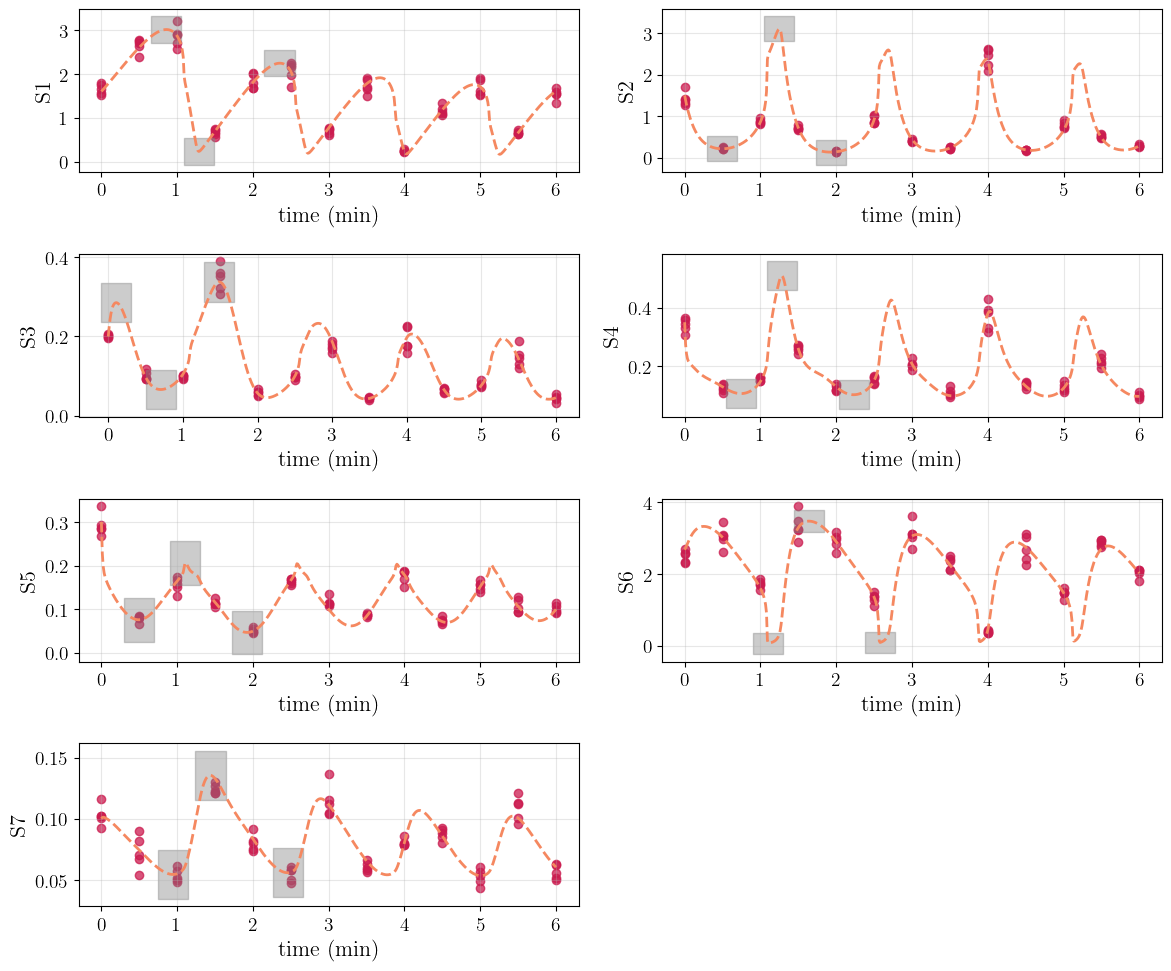

In [8]:
# Plot data, windows, and ground truth solutions
data_list = [dfData_S1, dfData_S2, dfData_S3, dfData_S4, dfData_S5, dfData_S6, dfData_S7]
qt_vars = [0,1,2,3,4,5,6]
windows_list = [dfWin_S1, dfWin_S2, dfWin_S3, dfWin_S4, dfWin_S5, dfWin_S6, dfWin_S7]
win_vars = [0,1,2,3,4,5,6]

labels = [f"S{i}" for i in range(1, 8)]
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
axs = axs.ravel()

# Plot ground truth and model dynamics
for i in range(7):
    axs[i].plot(dfGround['t'], dfGround.T.iloc[i+1], lw=2, ls='--', color=rocket_pal[2])
    axs[i].set_xlabel("time (min)")
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True, alpha=0.3)

# Plot data used to fit parameter
for data, i in zip(data_list, qt_vars):
    axs[i].scatter(data.iloc[:,0], data.iloc[:,1], marker='o', color=rocket_pal[1], alpha=0.75)

# Plot windows used to fit parameters
for windows, i in zip(windows_list, win_vars):
    for _, row in windows.iterrows():
        tmin, tmax = row['tmin'], row['tmax']
        ymin, ymax = row['Smin'], row['Smax']
        axs[i].fill_betweenx(
            [ymin, ymax], tmin, tmax, color='gray', alpha=0.4, label='Window' if _ == 0 else None
        )

axs[7].axis("off")
fig.tight_layout()
plt.show()

# Plotting bootstrap results

In [9]:
def simulations(dfParams, initialCond, t, simNum):
    S1 = []
    S2 = []
    S3 = []
    S4 = []
    S5 = []
    S6 = []
    S7 = []
    
    for i in range(simNum):
        k1 = dfParams['k1'][i]
        k2 = dfParams['k2'][i]
        k3 = dfParams['k3'][i]
        k4 = dfParams['k4'][i]
        k5 = dfParams['k5'][i]
        k6 = dfParams['k6'][i]
        k = dfParams['k'][i]
        kappa = dfParams['kappa'][i]
        K1 = dfParams['K1'][i]

        pars = np.array([k1, k2, k3, k4, k5, k6, k, kappa, K1])
    
        sol = odeint(modelG, initialCond, t, args=(pars,))
        
        S1.append(sol[:,0])
        S2.append(sol[:,1])
        S3.append(sol[:,2])
        S4.append(sol[:,3])
        S5.append(sol[:,4])
        S6.append(sol[:,5])
        S7.append(sol[:,6])

    return [S1, S2, S3, S4, S5, S6, S7]

In [14]:
colnames = [
    "replicate", "RSS",  # (RSS = cost function value)
    "k1", "k2", "k3", "k4", "k5", "k6", "k", "kappa", "K1"]

# colnames = [
#     "replicate", "RSS",  # (RSS = cost function value)
#     "$k_1$", "$k_2$", "$k_3$", "$k_4$", "$k_5$", "$k_6$", "$k$", "$\\kappa$", "$K_1$"]

dfPars_qt = pd.read_csv("glycolysis_data/results_noWin_5f_3w.csv", names=colnames, header=0)
dfPars_ql = pd.read_csv("glycolysis_data/results_win_5f_3w.csv", names=colnames, header=0)

In [15]:
initialCond = np.array([1.6, 1.5, 0.2, 0.35, 0.3, 2.67, 0.1], dtype=float)
t = np.linspace(0, 6, 501)

simNumber = dfPars_qt.shape[0]
S1qt, S2qt, S3qt, S4qt, S5qt, S6qt, S7qt = simulations(dfPars_qt, initialCond, t, simNumber)

simNumber = dfPars_ql.shape[0]
S1ql, S2ql, S3ql, S4ql, S5ql, S6ql, S7ql = simulations(dfPars_ql, initialCond, t, simNumber)

In [16]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
median_S1qt = np.median(S1qt, axis=0)
confidence_S1qt = np.percentile(S1qt, [2.5, 97.5], axis=0)

median_S2qt = np.median(S2qt, axis=0)
confidence_S2qt = np.percentile(S2qt, [2.5, 97.5], axis=0)

median_S3qt = np.median(S3qt, axis=0)
confidence_S3qt = np.percentile(S3qt, [2.5, 97.5], axis=0)

median_S4qt = np.median(S4qt, axis=0)
confidence_S4qt = np.percentile(S4qt, [2.5, 97.5], axis=0)

median_S5qt = np.median(S5qt, axis=0)
confidence_S5qt = np.percentile(S5qt, [2.5, 97.5], axis=0)

median_S6qt = np.median(S6qt, axis=0)
confidence_S6qt = np.percentile(S6qt, [2.5, 97.5], axis=0)

median_S7qt = np.median(S7qt, axis=0)
confidence_S7qt = np.percentile(S7qt, [2.5, 97.5], axis=0)

In [17]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
median_S1ql = np.median(S1ql, axis=0)
confidence_S1ql = np.percentile(S1ql, [2.5, 97.5], axis=0)

median_S2ql = np.median(S2ql, axis=0)
confidence_S2ql = np.percentile(S2ql, [2.5, 97.5], axis=0)

median_S3ql = np.median(S3ql, axis=0)
confidence_S3ql = np.percentile(S3ql, [2.5, 97.5], axis=0)

median_S4ql = np.median(S4ql, axis=0)
confidence_S4ql = np.percentile(S4ql, [2.5, 97.5], axis=0)

median_S5ql = np.median(S5ql, axis=0)
confidence_S5ql = np.percentile(S5ql, [2.5, 97.5], axis=0)

median_S6ql = np.median(S6ql, axis=0)
confidence_S6ql = np.percentile(S6ql, [2.5, 97.5], axis=0)

median_S7ql = np.median(S7ql, axis=0)
confidence_S7ql = np.percentile(S7ql, [2.5, 97.5], axis=0)

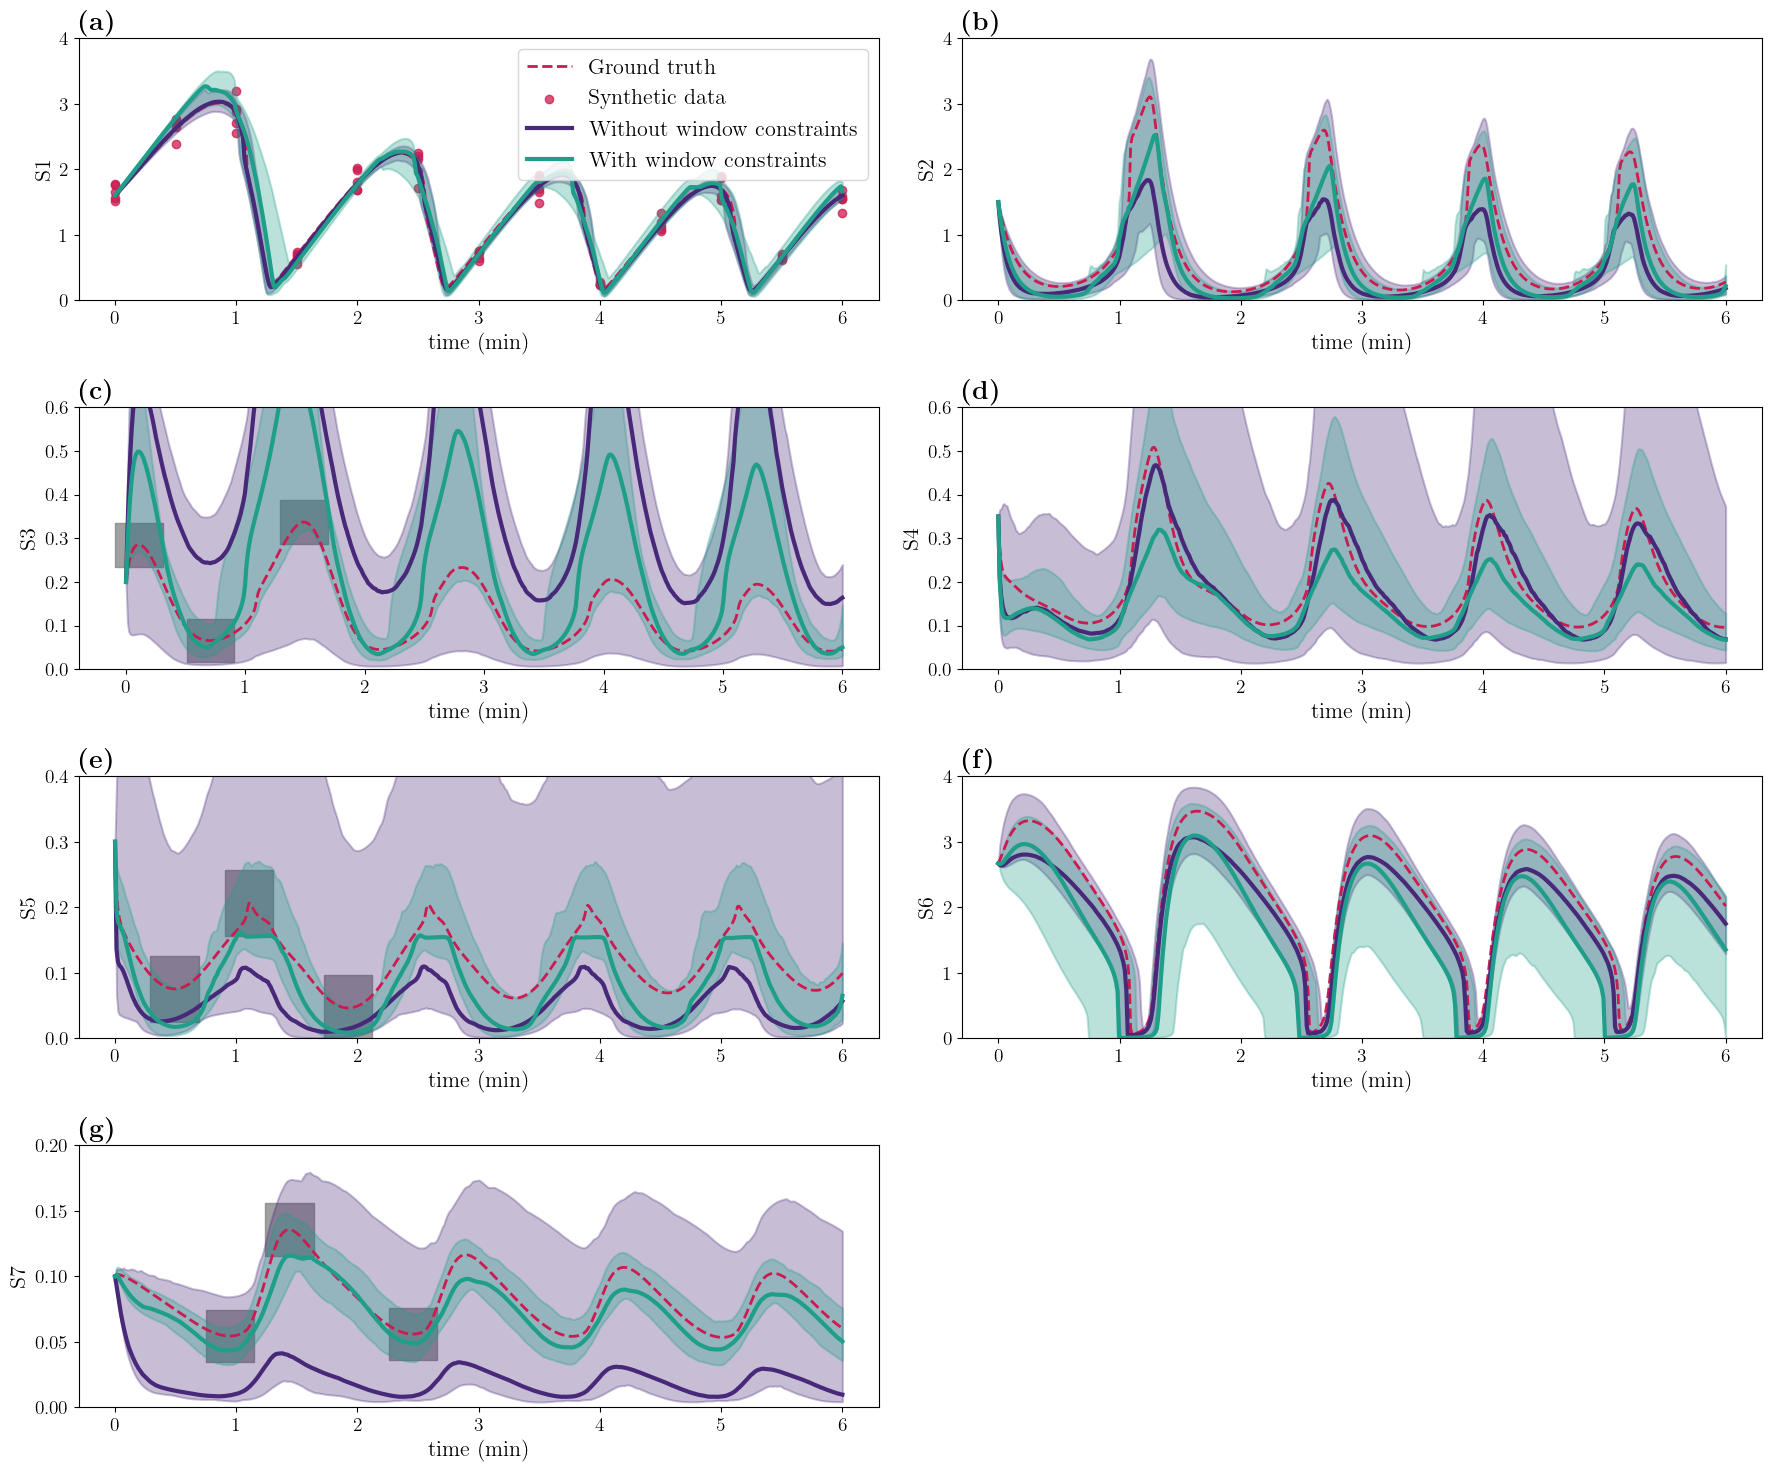

In [19]:
# Plot result
data_list = [dfData_S1]
qt_vars = [0]
# windows_list = [dfWin_S2, dfWin_S3, dfWin_S4, dfWin_S5, dfWin_S6, dfWin_S7]
# win_vars = [1,2,3,4,5,6]
windows_list = [dfWin_S3,dfWin_S5,dfWin_S7]
win_vars = [2,4,6]
# windows_list = [dfWin_S3,dfWin_S7]
# win_vars = [2,6]

labels = [f"S{i}" for i in range(1, 8)]
fig, axs = plt.subplots(4, 2, figsize=(18, 15))

# fig.suptitle('5-fold parameter search space and 3 window variables', fontsize=16)
# fig.suptitle('2-fold parameter search space and 6 window variables', fontsize=16)

axs = axs.ravel()
# Plot ground truth and model dynamics
for i in range(7):
    axs[i].plot(dfGround['t'], dfGround.T.iloc[i+1], lw=2, ls='--', color=rocket_pal[1], label='Ground truth')
    axs[i].set_xlabel("time (min)")
    axs[i].set_ylabel(labels[i])
    # axs[i].grid(True, alpha=0.3)

# Plot data used to fit parameter
for data, i in zip(data_list, qt_vars):
    axs[i].scatter(data.iloc[:,0], data.iloc[:,1], marker='o', color=rocket_pal[1], alpha=0.75, label="Synthetic data")

# Plot windows used to fit parameters
for windows, i in zip(windows_list, win_vars):
    for _, row in windows.iterrows():
        tmin, tmax = row['tmin'], row['tmax']
        ymin, ymax = row['Smin'], row['Smax']
        axs[i].fill_betweenx(
            [ymin, ymax], tmin, tmax, color='gray', alpha=0.75, label='Window' if _ == 0 else None
        )

# Quantitative estimations solutions
axs[0].plot(t, median_S1qt, lw=3, color=viridis_pal[0], label='Without window constraints')
axs[0].fill_between(t, confidence_S1qt[0], confidence_S1qt[1], color=viridis_pal[0], alpha=0.3, lw=1.5)

axs[1].plot(t, median_S2qt, lw=3, color=viridis_pal[0])
axs[1].fill_between(t, confidence_S2qt[0], confidence_S2qt[1], color=viridis_pal[0], alpha=0.3, lw=1.5)

axs[2].plot(t, median_S3qt, lw=3, color=viridis_pal[0])
axs[2].fill_between(t, confidence_S3qt[0], confidence_S3qt[1], color=viridis_pal[0], alpha=0.3, lw=1.5)

axs[3].plot(t, median_S4qt, lw=3, color=viridis_pal[0])
axs[3].fill_between(t, confidence_S4qt[0], confidence_S4qt[1], color=viridis_pal[0], alpha=0.3, lw=1.5)

axs[4].plot(t, median_S5qt, lw=3, color=viridis_pal[0])
axs[4].fill_between(t, confidence_S5qt[0], confidence_S5qt[1], color=viridis_pal[0], alpha=0.3, lw=1.5)

axs[5].plot(t, median_S6qt, lw=3, color=viridis_pal[0])
axs[5].fill_between(t, confidence_S6qt[0], confidence_S6qt[1], color=viridis_pal[0], alpha=0.3, lw=1.5)

axs[6].plot(t, median_S7qt, lw=3, color=viridis_pal[0])
axs[6].fill_between(t, confidence_S7qt[0], confidence_S7qt[1], color=viridis_pal[0], alpha=0.3, lw=1.5)

# Quanlitative estimations solutions
axs[0].plot(t, median_S1ql, lw=3, color=viridis_pal[4], label='With window constraints')
axs[0].fill_between(t, confidence_S1ql[0], confidence_S1ql[1], color=viridis_pal[4], alpha=0.3, lw=1.5)

axs[1].plot(t, median_S2ql, lw=3, color=viridis_pal[4])
axs[1].fill_between(t, confidence_S2ql[0], confidence_S2ql[1], color=viridis_pal[4], alpha=0.3, lw=1.5)

axs[2].plot(t, median_S3ql, lw=3, color=viridis_pal[4])
axs[2].fill_between(t, confidence_S3ql[0], confidence_S3ql[1], color=viridis_pal[4], alpha=0.3, lw=1.5)

axs[3].plot(t, median_S4ql, lw=3, color=viridis_pal[4])
axs[3].fill_between(t, confidence_S4ql[0], confidence_S4ql[1], color=viridis_pal[4], alpha=0.3, lw=1.5)

axs[4].plot(t, median_S5ql, lw=3, color=viridis_pal[4])
axs[4].fill_between(t, confidence_S5ql[0], confidence_S5ql[1], color=viridis_pal[4], alpha=0.3, lw=1.5)

axs[5].plot(t, median_S6ql, lw=3, color=viridis_pal[4])
axs[5].fill_between(t, confidence_S6ql[0], confidence_S6ql[1], color=viridis_pal[4], alpha=0.3, lw=1.5)

axs[6].plot(t, median_S7ql, lw=3, color=viridis_pal[4])
axs[6].fill_between(t, confidence_S7ql[0], confidence_S7ql[1], color=viridis_pal[4], alpha=0.3, lw=1.5)

axs[0].set_ylim(0,4)
axs[1].set_ylim(0,4)
axs[5].set_ylim(0,4)

axs[2].set_ylim(0,0.6)
axs[3].set_ylim(0,0.6)
axs[4].set_ylim(0,0.4)
axs[6].set_ylim(0,0.2)

axs[0].set_title(r'\bf{(a)}', loc='left')
axs[1].set_title(r'\bf{(b)}', loc='left')
axs[2].set_title(r'\bf{(c)}', loc='left')
axs[3].set_title(r'\bf{(d)}', loc='left')
axs[4].set_title(r'\bf{(e)}', loc='left')
axs[5].set_title(r'\bf{(f)}', loc='left')
axs[6].set_title(r'\bf{(g)}', loc='left')

axs[0].legend()

axs[7].axis("off")
fig.tight_layout()

plt.show()

In [20]:
df_bootstrap_noWin = dfPars_qt.drop(['replicate', 'RSS'], axis=1)
df_bootstrap_win = dfPars_ql.drop(['replicate', 'RSS'], axis=1)

In [21]:
df_noWin_long = df_bootstrap_noWin.melt(var_name="Parameter", value_name="Value")
df_noWin_long["Strategy"] = "Without windows"

df_win_long = df_bootstrap_win.melt(var_name="Parameter", value_name="Value")
df_win_long["Strategy"] = "With windows"

# Combine both into a single long-format DataFrame
df_bootstrap_all = pd.concat([df_noWin_long, df_win_long], ignore_index=True)

In [22]:
param_names = df_bootstrap_noWin.columns.tolist()
df_ground = pd.DataFrame({"Parameter": param_names, "Value": groundParams})

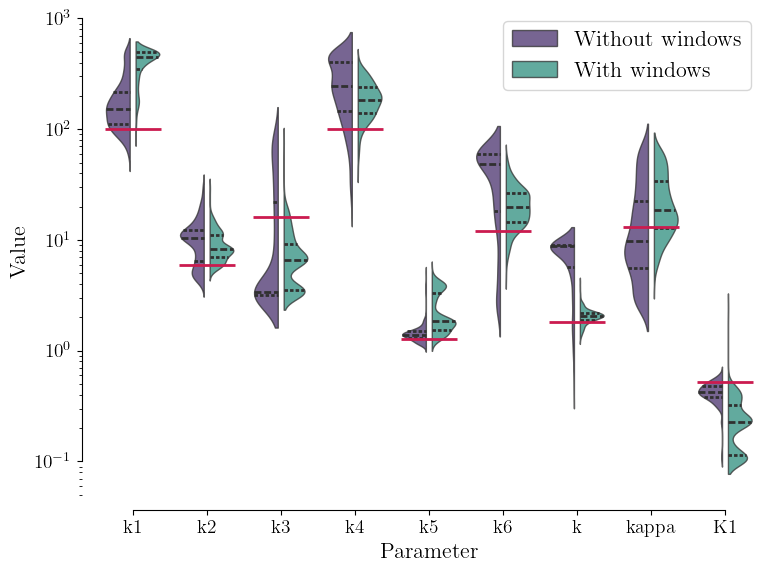

In [24]:
colors = [viridis_pal[0], viridis_pal[4]]

plt.figure(figsize=(8, 6), facecolor="white")

# Violin plot for bootstrap distributions
sns.violinplot(
    data=df_bootstrap_all,
    x="Parameter",
    y="Value",
    hue="Strategy",
    log_scale=True,
    palette=colors,
    alpha=0.75,
    linewidth=1.0,
    density_norm="count",
    split=True,
    gap=0.2,
    inner="quart",  # show quartiles
    inner_kws=dict(linewidth=2)
)

# Ground truth as a horizontal marker for each parameter
sns.pointplot(
    data=df_ground,
    x="Parameter",
    y="Value",
    color=rocket_pal[1],   # ground truth marker color
    linestyle="none",
    marker="_",
    markersize=40,
    markeredgewidth=2
)

sns.despine(offset=10, trim=True)

plt.tight_layout()

plt.show()